# Analysis of True Price ABM

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import cProfile
import pstats
import mesa
pd.set_option('display.max_colwidth', 10000)
import joblib
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami

/var/folders/53/cl5y6r2x7n5_942j6h59yyh00000gn/T/ipykernel_43336/2138495846.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#from model import ConsumatModel
from model_homophily import ConsumatModel

In [3]:
#Import KDE models

kde_modeks = {
    'ccrdprs': joblib.load('saved_data/kde_ccrdprs.pkl'),
    'gvsrdcc': joblib.load('saved_data/kde_gvsrdcc.pkl'),
    'hincfel': joblib.load('saved_data/kde_hincfel.pkl'),
    'impenv': joblib.load('saved_data/kde_impenv.pkl'),
    'impfree': joblib.load('saved_data/kde_impfree.pkl'),
    'imprich': joblib.load('saved_data/kde_imprich.pkl'),
    'inctxff': joblib.load('saved_data/kde_inctxff.pkl'),
    'inprdsc': joblib.load('saved_data/kde_inprdsc.pkl'),
    'ipfrule': joblib.load('saved_data/kde_ipfrule.pkl'),
    'iplylfr': joblib.load('saved_data/kde_iplylfr.pkl'),
    'lkredcc': joblib.load('saved_data/kde_lkredcc.pkl'),
    'sclmeet': joblib.load('saved_data/kde_sclmeet.pkl'),
    'wrclmch': joblib.load('saved_data/kde_wrclmch.pkl'),
    'wrkctra': joblib.load('saved_data/kde_wrkctra.pkl')
}

In [4]:
base_config = {
    'TP_percentage': 0.7,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'kde_models_dir': 'saved_data/',
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'seed': 42  # Seed for reproducibility
}


# Configuration for SDA networks with different homophily attributes
sda_conformity_config = base_config.copy()
sda_conformity_config.update({
    'network_type': 'sda',
    'network_params': {
        'n': 1000,
        'alpha': 5,
        'b': 0.1,
        'homophily_attribute': 'preference_conformity'
    }
})

sda_sustainability_config = base_config.copy()
sda_sustainability_config.update({
    'network_type': 'sda',
    'network_params': {
        'n': 1000,
        'alpha': 5,
        'b': 0.1,
        'homophily_attribute': 'preference_sustainability'
    }
})

sda_financial_config = base_config.copy()
sda_financial_config.update({
    'network_type': 'sda',
    'network_params': {
        'n': 1000,
        'alpha': 5,
        'b': 0.1,
        'homophily_attribute': 'weight_financial'
    }
})

sda_social_config = base_config.copy()
sda_social_config.update({
    'network_type': 'sda',
    'network_params': {
        'n': 1000,
        'alpha': 5,
        'b': 0.1,
        'homophily_attribute': 'weight_social'
    }
})

sda_personal_config = base_config.copy()
sda_personal_config.update({
    'network_type': 'sda',
    'network_params': {
        'n': 1000,
        'alpha': 5,
        'b': 0.1,
        'homophily_attribute': 'weight_personal'
    }
})


In [5]:

def run_simulation(model, num_steps):
    # List to store True Price Adoption Rates
    adoption_rates = []

    # Run the model for a specified number of steps with tqdm for progress tracking
    for _ in tqdm(range(num_steps), desc='Simulation Progress'):
        model.step()
        # Calculate and append the current adoption rate to the list
        current_adoption_rate = model.calculate_true_price_adoption_rate()
        adoption_rates.append(current_adoption_rate)

    # Retrieve collected data from the model's DataCollector
    model_data = model.datacollector.get_model_vars_dataframe()
    # Append the adoption rates to the DataFrame
    model_data['Adoption Rates'] = adoption_rates  # Ensure this matches how you collect data in DataCollector

    return model_data

def run_all_simulations(configurations, num_steps):
    results = {}
    for config_name, config in configurations.items():
        print(f"Running simulation for {config_name} network...")
        model = ConsumatModel(config)  # Pass the configuration as a single argument
        result = run_simulation(model, num_steps)
        results[config_name] = result

        # Plotting True Price Adoption Rates
        plt.figure(figsize=(10, 6))
        plt.plot(result['Adoption Rates'], marker='o', color='b')
        plt.title(f'True Price Adoption Rate Over Iterations for {config_name}')
        plt.xlabel('Iteration')
        plt.ylabel('True Price Adoption Rate (%)')
        plt.grid(True)
        plt.show()

        # Plotting Network Metrics
        plt.figure(figsize=(10, 5))
        plt.plot(result['Average Degree'], label='Average Degree')
        plt.plot(result['Variance of Degree'], label='Variance of Degree')
        plt.plot(result['Average Clustering'], label='Average Clustering')
        if 'Average Path Length' in result.columns:
            plt.plot(result['Average Path Length'], label='Average Path Length', linestyle='--')
        plt.xlabel('Step')
        plt.ylabel('Metric Value')
        plt.title(f'Network Metrics Over Time for {config_name}')
        plt.legend()
        plt.show()

    return results

# Define the configurations for each network type
network_configurations = {
    'Conformity SDA': sda_conformity_config,
    'Financial SDA': sda_financial_config,
    'Personal SDA': sda_personal_config,
    'Social SDA': sda_social_config,
    'Sustainability SDA': sda_sustainability_config
}



Running simulation for Conformity SDA network...


Simulation Progress: 100%|██████████| 10/10 [08:44<00:00, 52.46s/it]


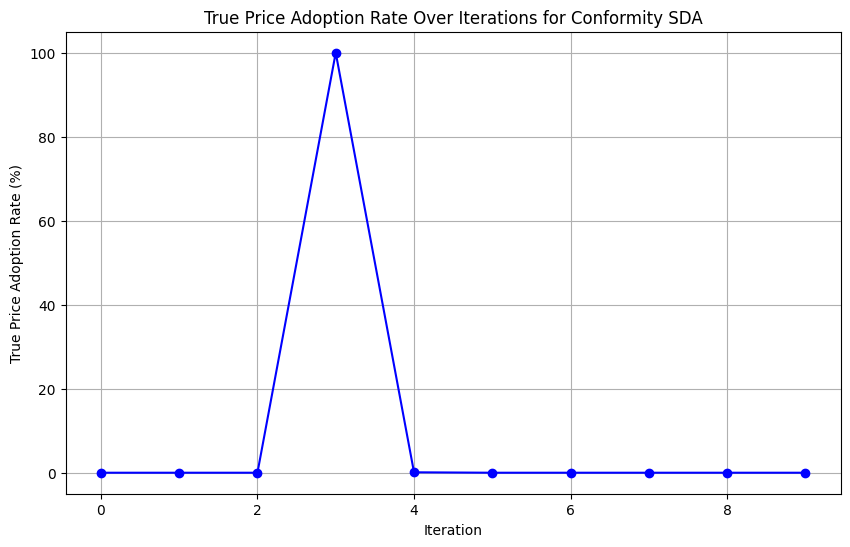

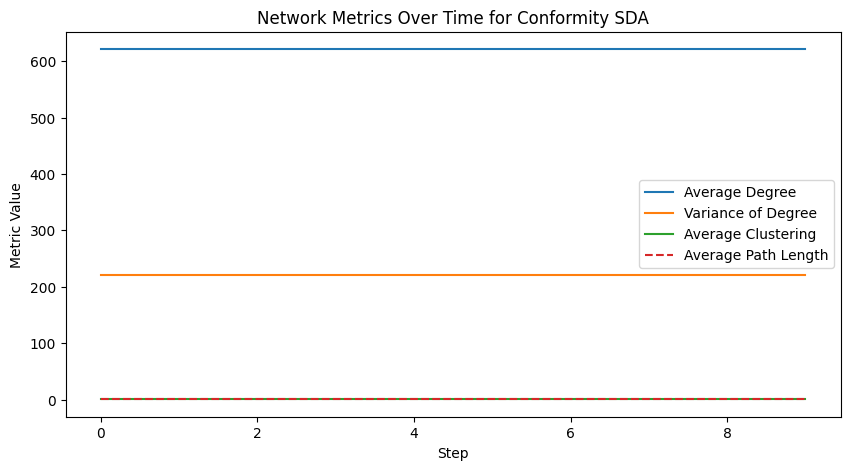

Running simulation for Financial SDA network...


Simulation Progress: 100%|██████████| 10/10 [08:37<00:00, 51.76s/it]


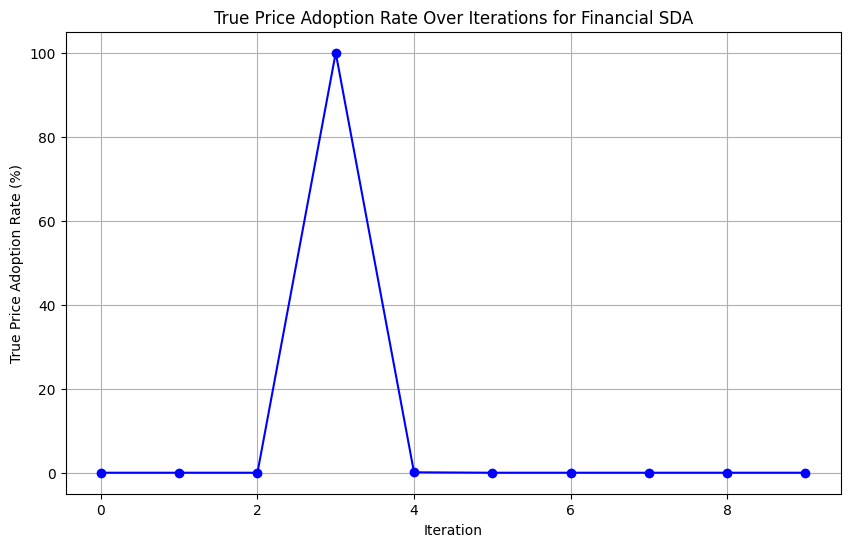

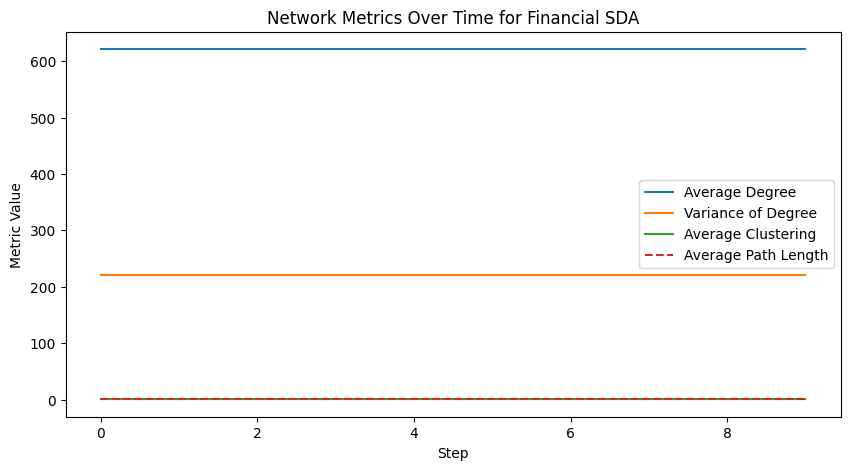

Running simulation for Personal SDA network...


Simulation Progress: 100%|██████████| 10/10 [08:38<00:00, 51.83s/it]


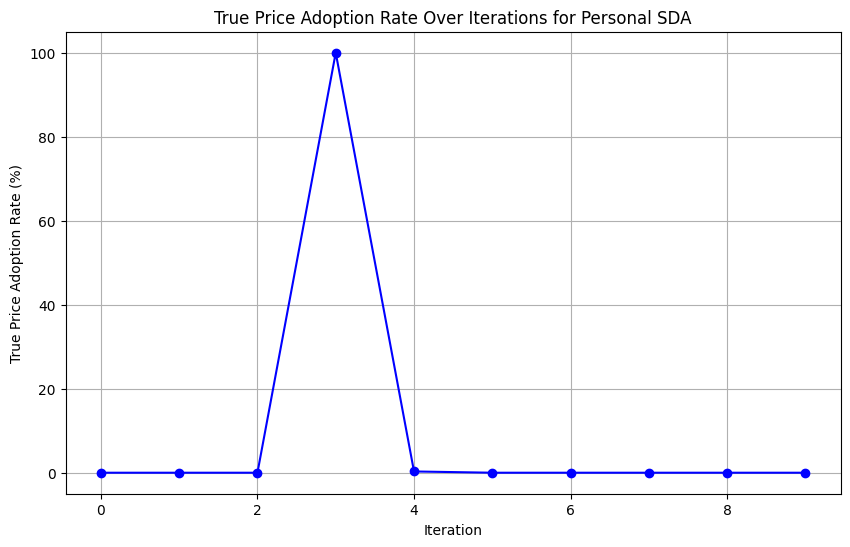

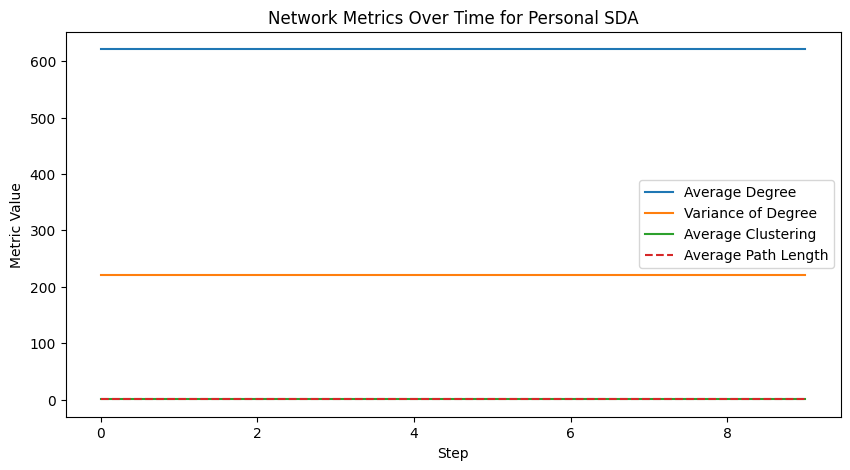

Running simulation for Social SDA network...


Simulation Progress: 100%|██████████| 10/10 [08:36<00:00, 51.65s/it]


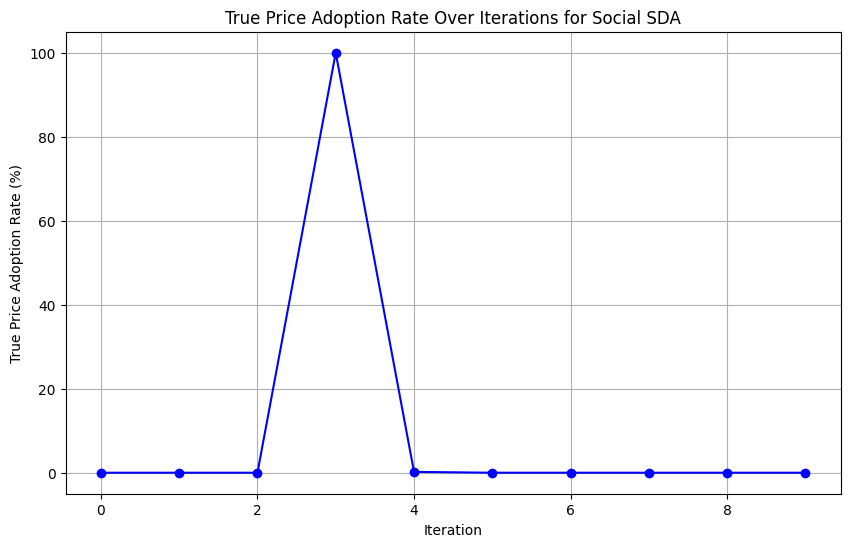

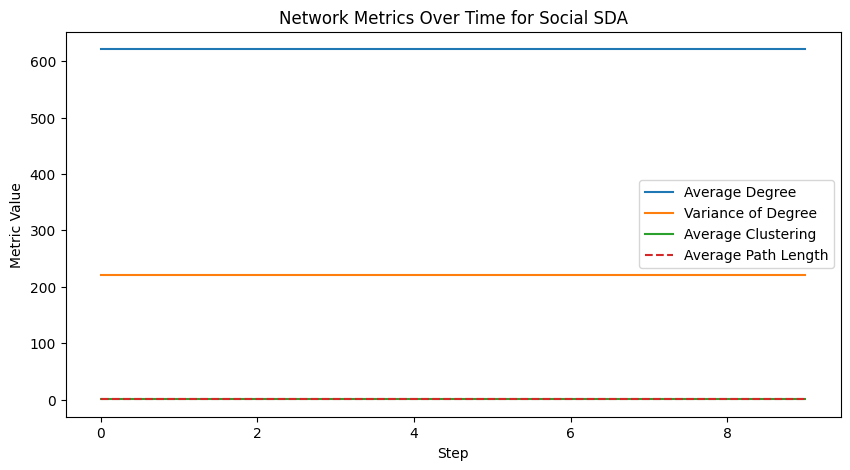

Running simulation for Sustainability SDA network...


Simulation Progress: 100%|██████████| 10/10 [08:39<00:00, 51.96s/it]


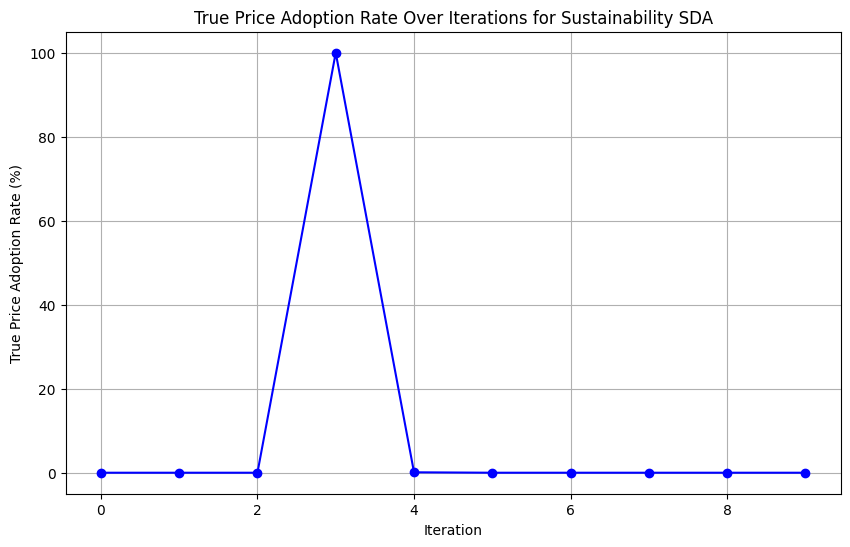

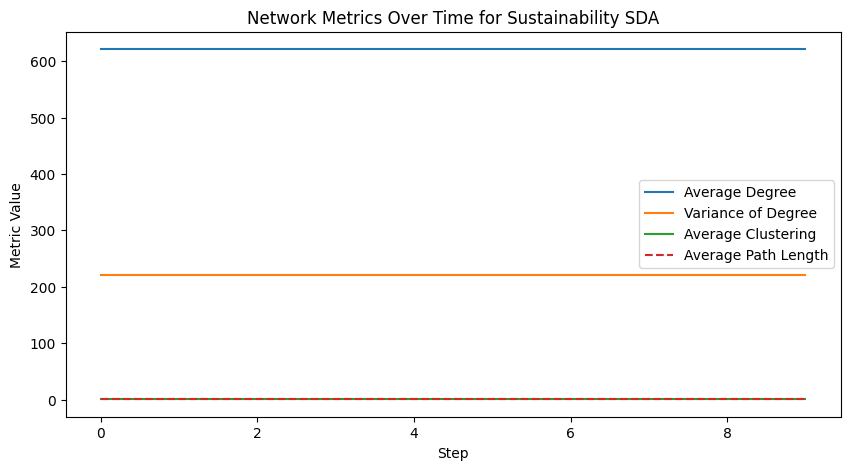

Results for Conformity SDA:
    Average Degree  Variance of Degree  Average Clustering  \
0         621.202          220.381196            0.621773   
1         621.202          220.381196            0.621773   
2         621.202          220.381196            0.621773   
3         621.202          220.381196            0.621773   
4         621.202          220.381196            0.621773   

   Average Path Length  Adoption Rates  
0             1.378176             0.0  
1             1.378176             0.0  
2             1.378176             0.0  
3             1.378176           100.0  
4             1.378176             0.1  
Results for Financial SDA:
    Average Degree  Variance of Degree  Average Clustering  \
0         621.202          220.381196            0.621773   
1         621.202          220.381196            0.621773   
2         621.202          220.381196            0.621773   
3         621.202          220.381196            0.621773   
4         621.202        

In [6]:
# Execute the simulations for all network configurations
results = run_all_simulations(network_configurations, 10)

# Print or process the results
for network_type, data in results.items():
    print(f"Results for {network_type}:\n", data.head())

In [8]:
# Assuming the required functions are available
# from your_model_module import ConsumatModel, run_simulation

# Define a function to iterate through TP percentages and produce visualizations
def run_simulation_with_tp_percentages(model_class, config, tp_percentages, num_steps):
    final_adoption_rates = []
    all_adoption_rates = []

    for tp_percentage in tp_percentages:
        config['TP_percentage'] = tp_percentage
        model = model_class(config)
        model_data = run_simulation(model, num_steps)

        # Collect data for plotting
        final_adoption_rates.append(model_data['Adoption Rates'].iloc[-1])
        all_adoption_rates.append(model_data['Adoption Rates'].values)

    return final_adoption_rates, all_adoption_rates

# Define the TP percentages and simulation steps
tp_percentages = np.linspace(0.1, 0.9, 19)
num_steps = 10

# Define the configurations for each network type
network_configurations = {
    'Conformity SDA': sda_conformity_config,
    'Financial SDA': sda_financial_config,
    'Personal SDA': sda_personal_config,
    'Social SDA': sda_social_config,
    'Sustainability SDA': sda_sustainability_config
}

# Modify the run_all_simulations function to incorporate simulations by TP percentages
def run_all_simulations(configurations, tp_percentages, num_steps):
    results = {}

    for config_name, config in configurations.items():
        print(f"Running simulation for {config_name} network...")

        final_adoption_rates, all_adoption_rates = run_simulation_with_tp_percentages(ConsumatModel, config, tp_percentages, num_steps)

        # Store results for each configuration
        results[config_name] = (final_adoption_rates, all_adoption_rates)

        # Plot Final Adoption Rate by TP percentage
        plt.figure(figsize=(20, 12))

        plt.subplot(2, 1, 1)
        plt.plot(tp_percentages, final_adoption_rates, marker='o')
        plt.title(f'Final Adoption Rate ({config_name})')
        plt.xlabel('TP_percentage')
        plt.ylabel('Final True Price Adoption Rate (%)')
        plt.grid(True)

        # Plot Adoption Rate Dynamics by TP percentage
        plt.subplot(2, 1, 2)
        for i, rates in enumerate(all_adoption_rates):
            plt.plot(range(1, num_steps + 1), rates, label=f'TP_percentage = {tp_percentages[i]:.2f}', marker='o')

        plt.title(f'Adoption Dynamics ({config_name})')
        plt.xlabel('Iteration')
        plt.ylabel('Adoption Rate (%)')
        plt.legend(title='TP_percentage')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    return results


Running simulation for Conformity SDA network...


Simulation Progress: 100%|██████████| 10/10 [07:50<00:00, 47.09s/it]


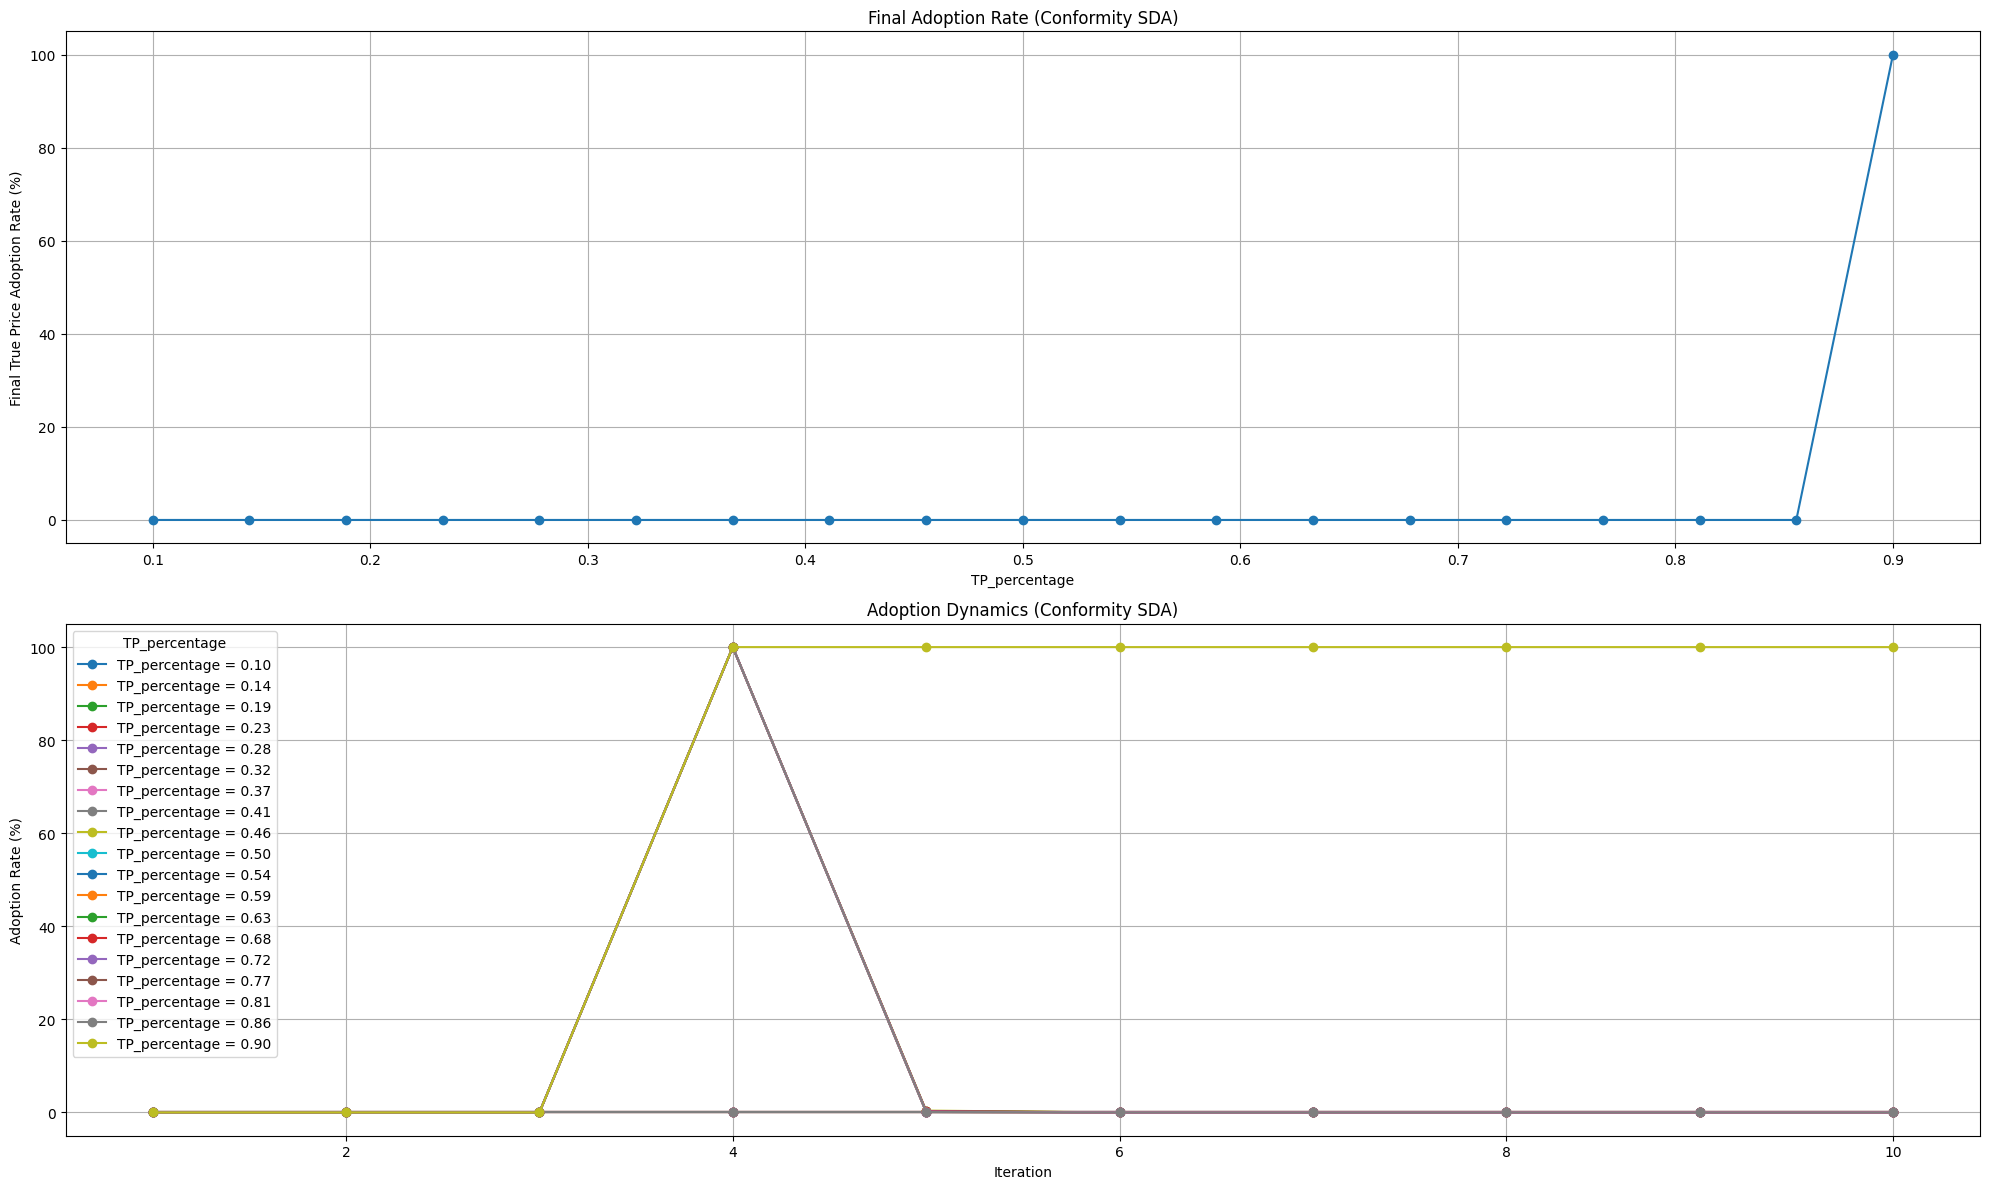

Running simulation for Financial SDA network...


Simulation Progress: 100%|██████████| 10/10 [06:19<00:00, 37.95s/it]


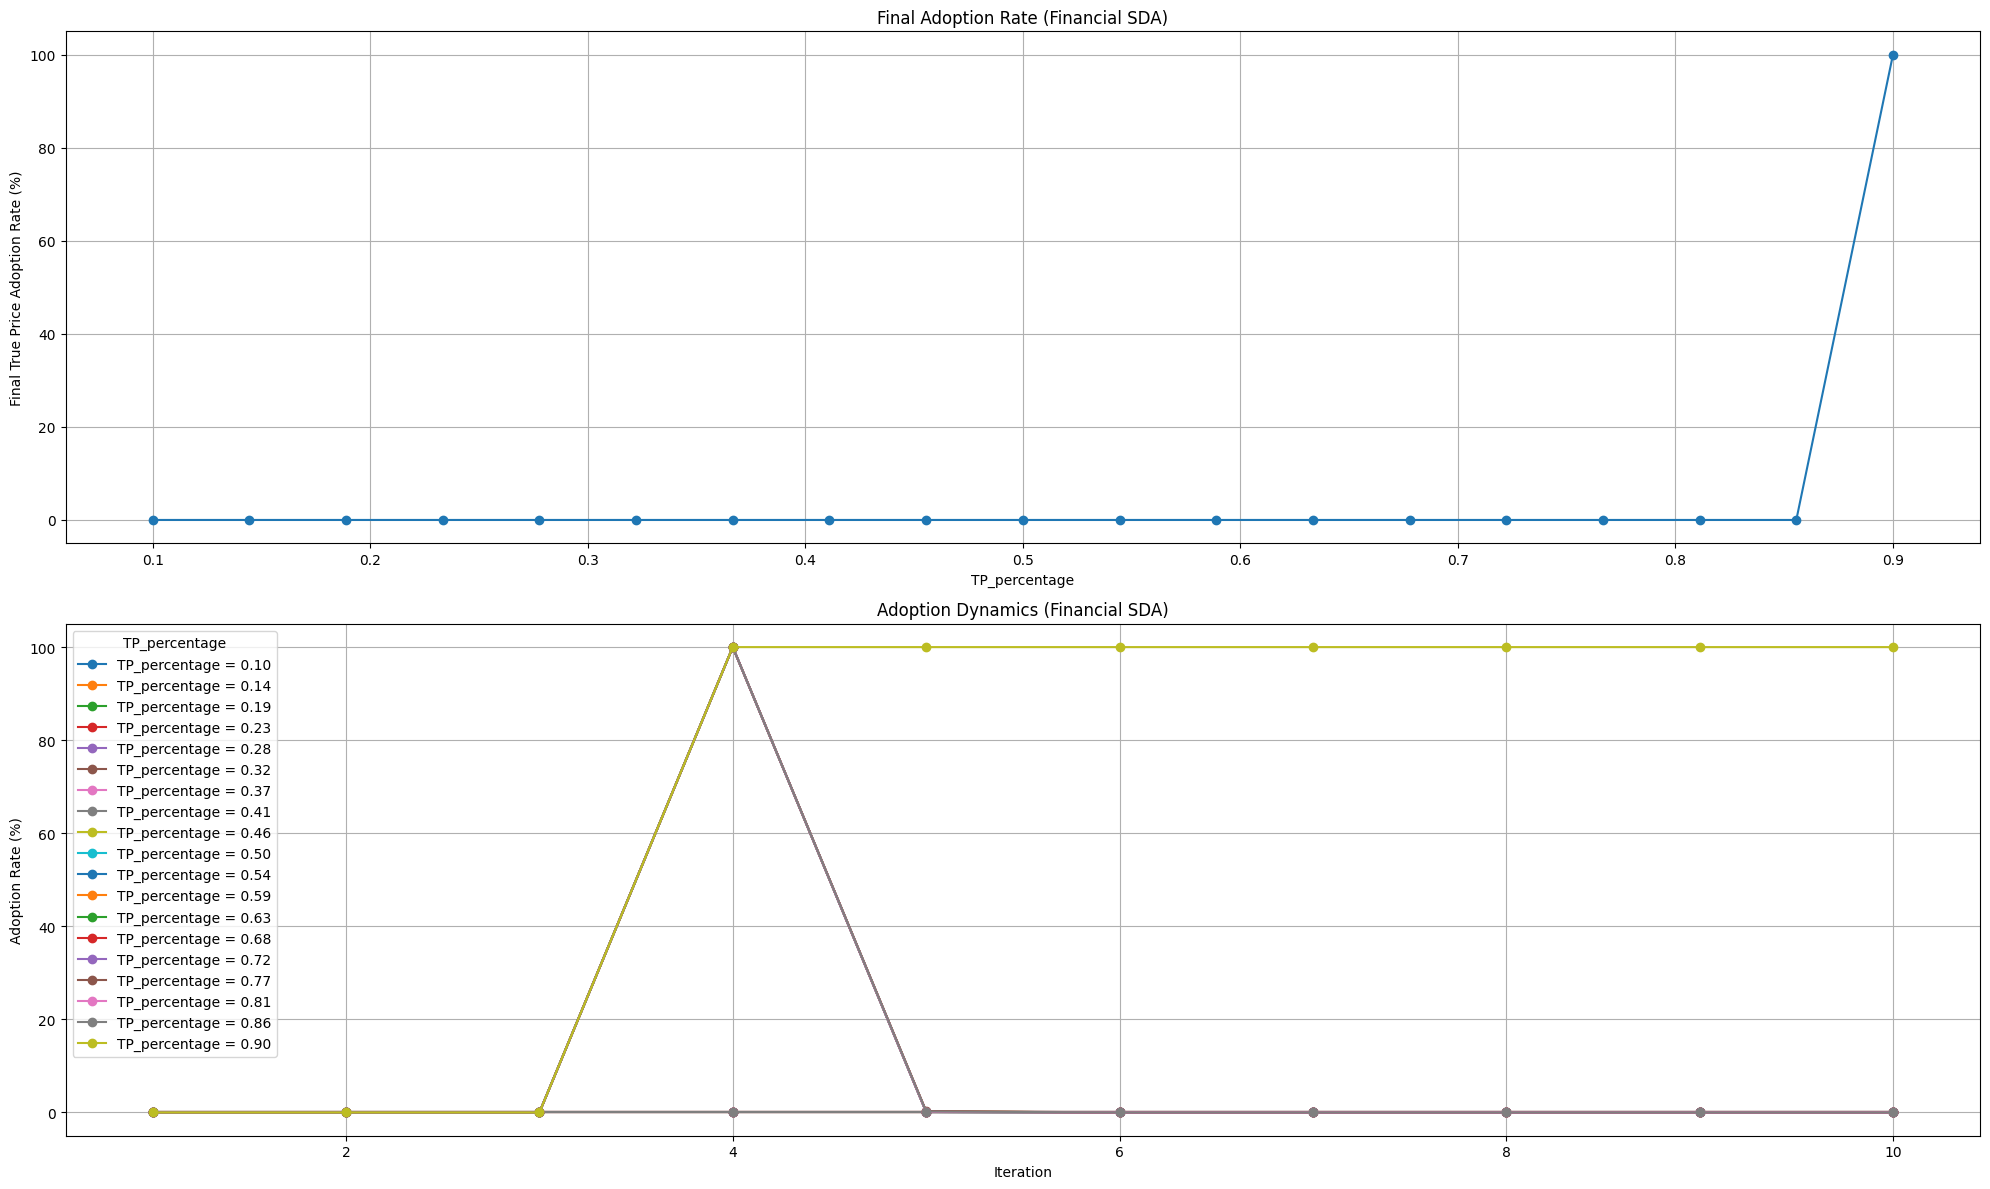

Running simulation for Personal SDA network...


Simulation Progress: 100%|██████████| 10/10 [09:16<00:00, 55.70s/it]


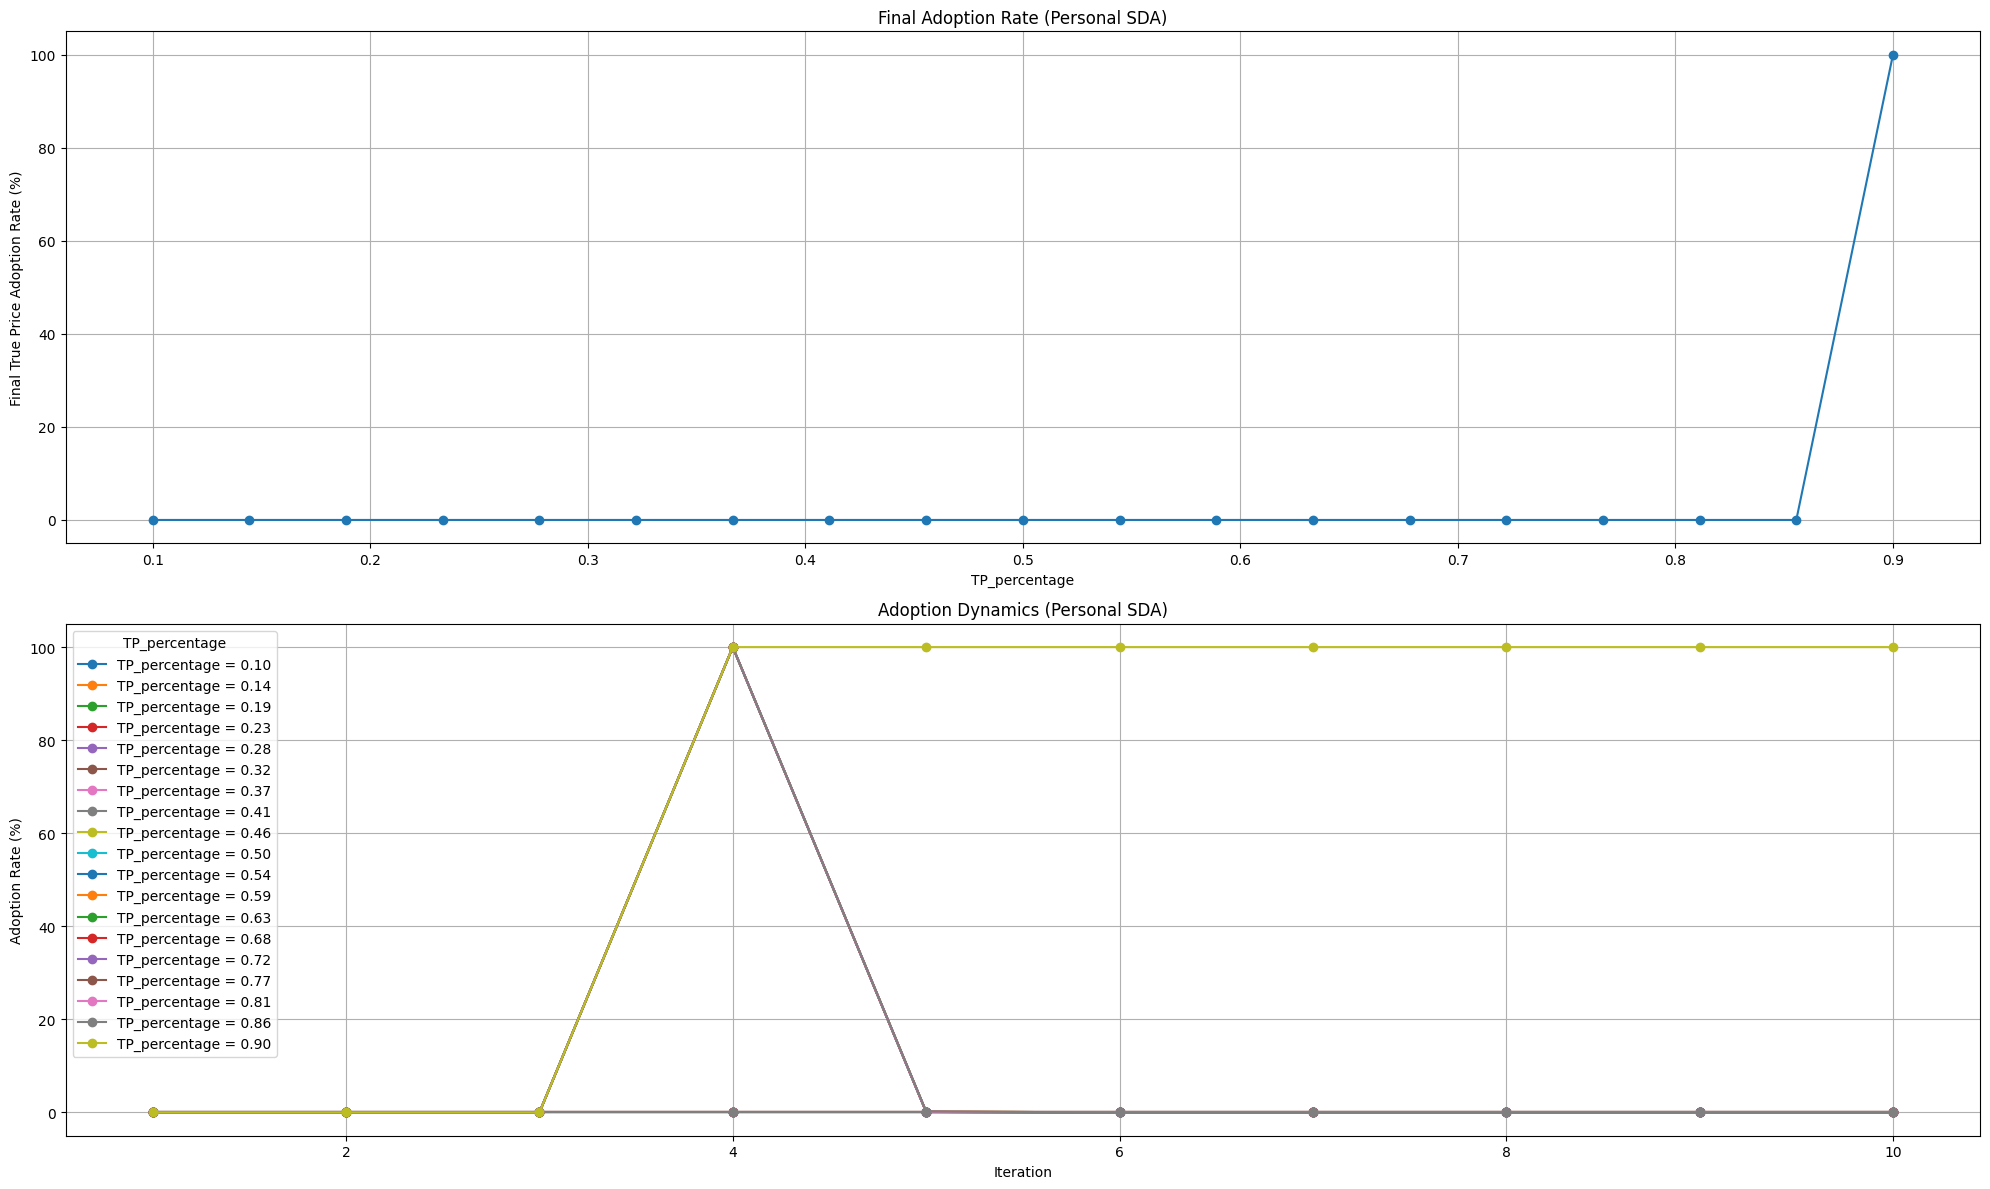

Running simulation for Social SDA network...


Simulation Progress: 100%|██████████| 10/10 [05:26<00:00, 32.62s/it]


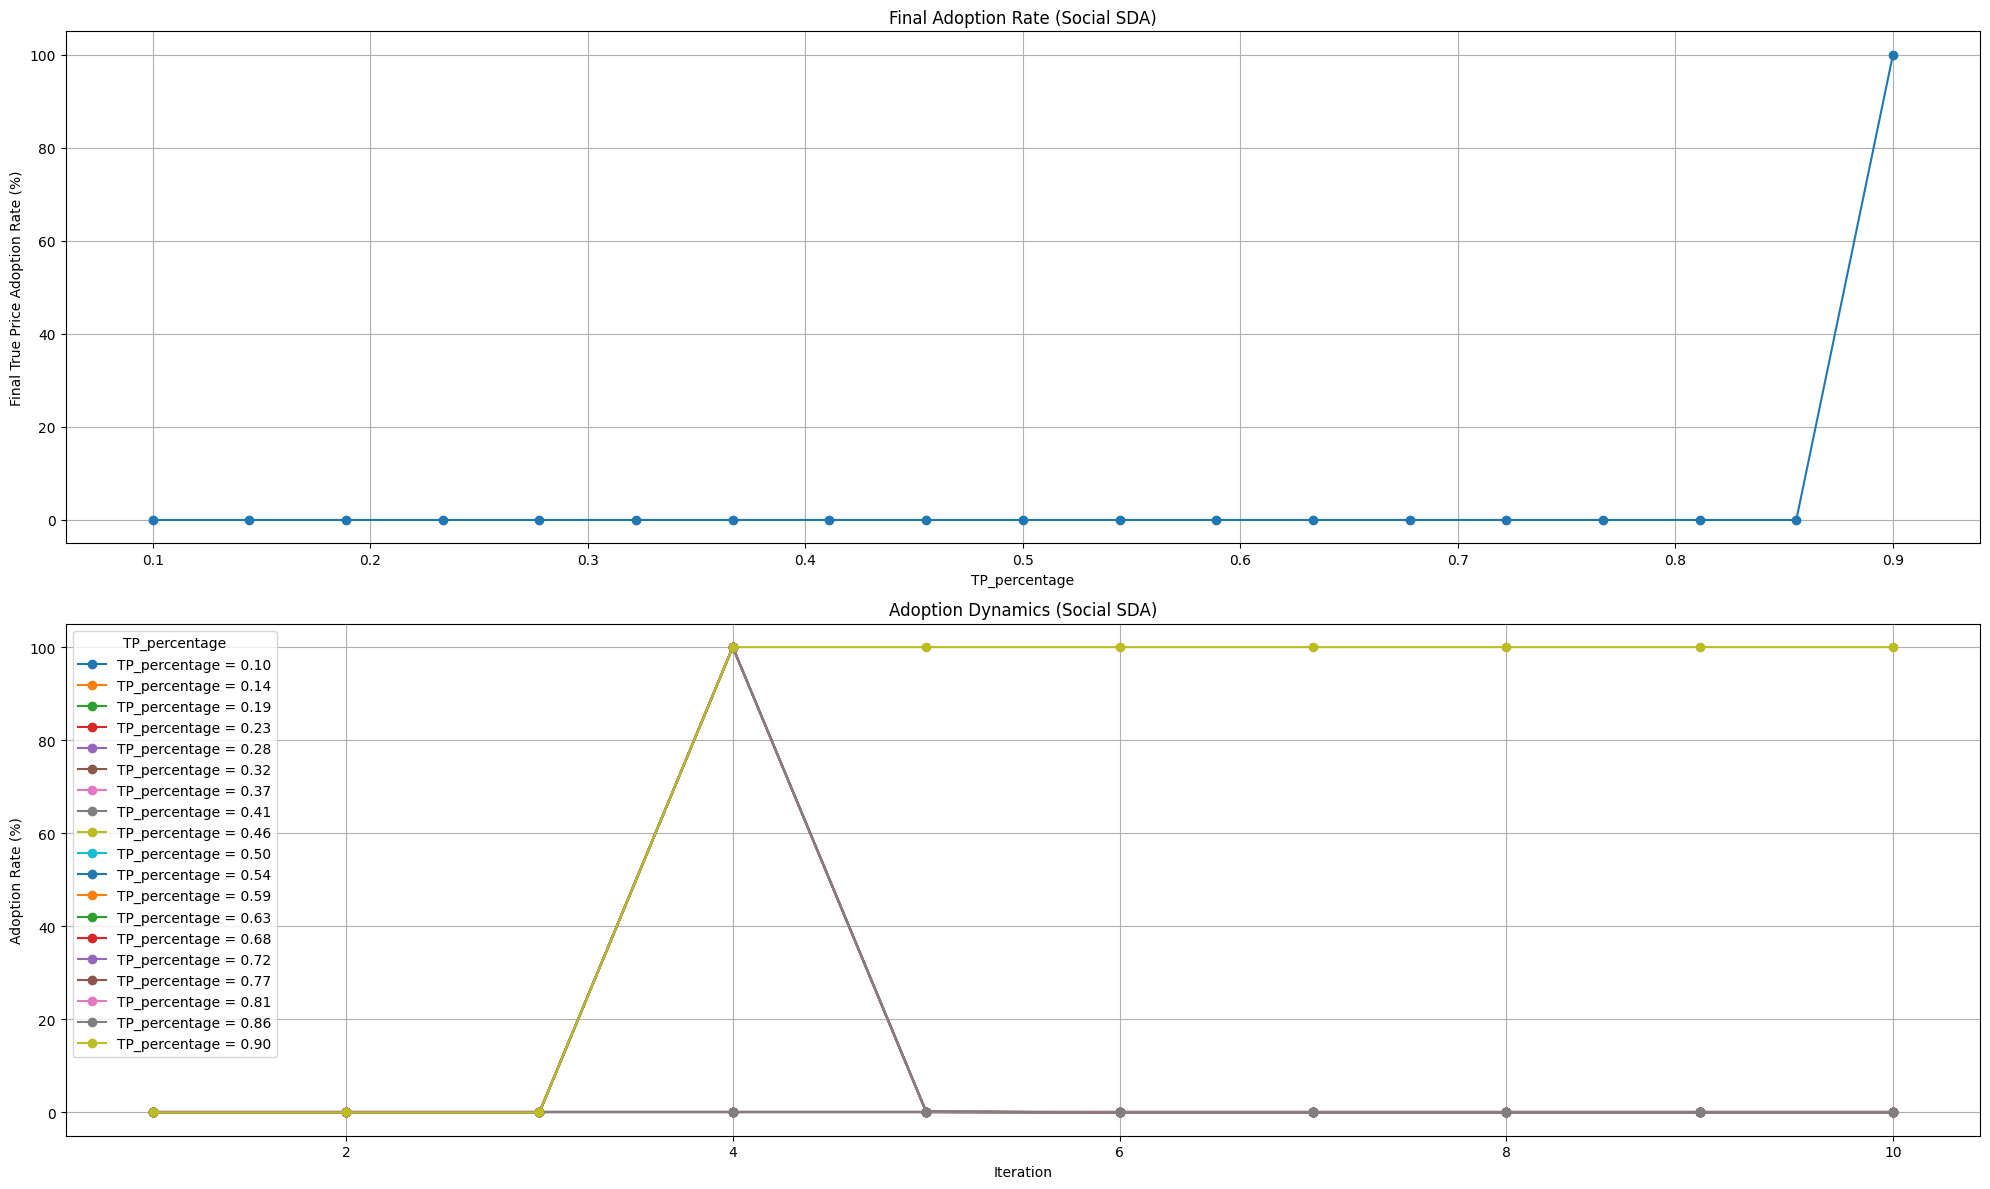

Running simulation for Sustainability SDA network...


Simulation Progress: 100%|██████████| 10/10 [05:22<00:00, 32.29s/it]


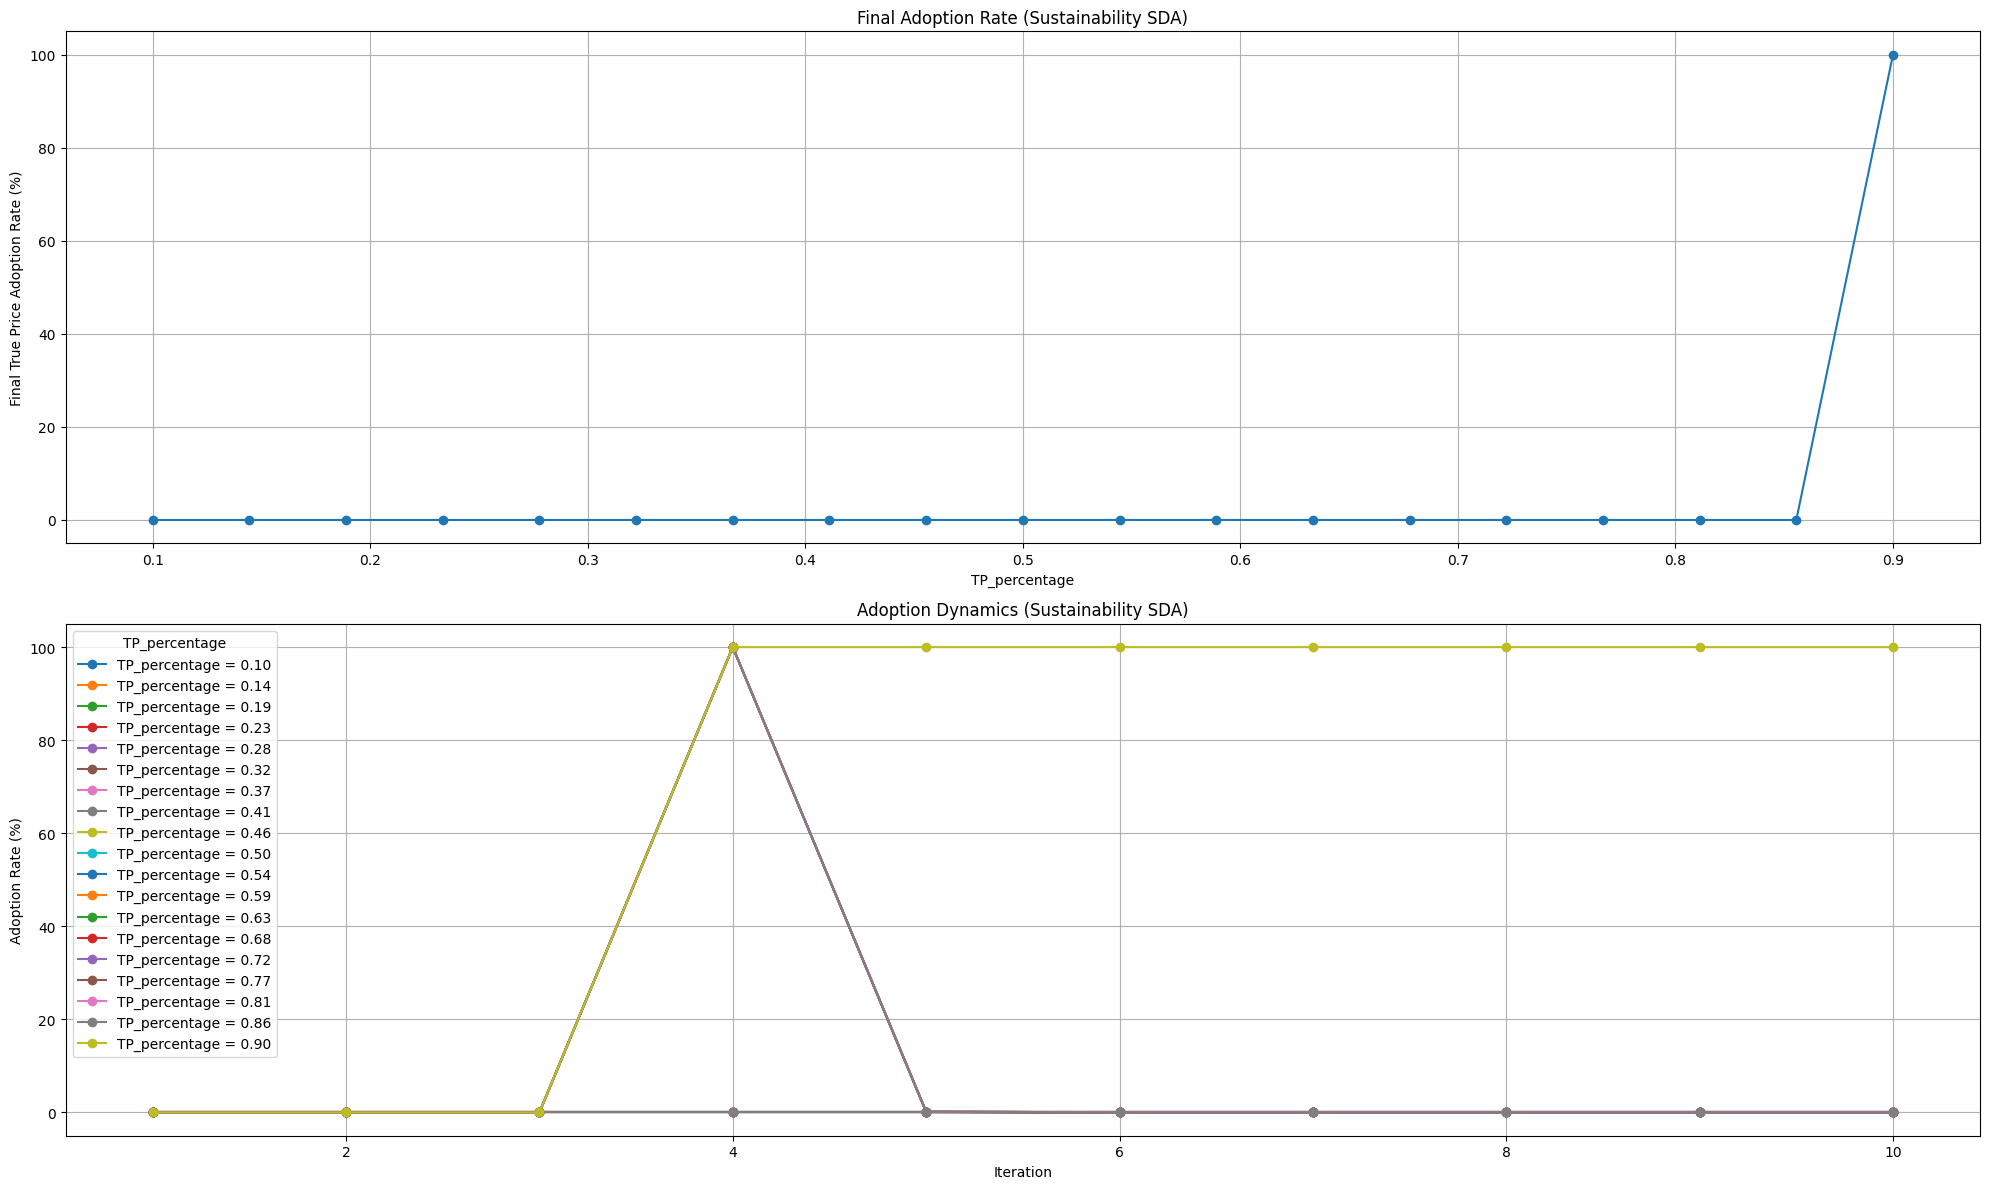

{'Conformity SDA': ([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 100.0], [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([  0. ,   0. ,   0. , 100. ,   0.4,   0. ,   0. ,   0. ,   0. ,
         0. ]), array([  0. ,   0. ,   0. , 100. ,   0.1,   0. ,   0. ,   0. ,   0. ,
         0. ]), array([  0. ,   0. ,   0. , 100. ,   0.2,   0. ,   0. ,   0. ,   0. ,
         0. ]), array([  0. ,   0. ,   0. , 100. ,   0.1,   0. ,   0. ,   0. ,   0. ,
         0. ]), array([  0. ,   0. ,   0. , 100. ,   0.3,   0. ,   0. ,   0. ,   0. ,
         0. ]), array([  0. ,   0. ,   0. , 100. ,   0.3,   0. ,   0. ,   

In [9]:
results = run_all_simulations(network_configurations, tp_percentages, num_steps)
print(results)

### Multiple runs of the same model:

In [7]:
# Number of simulations
num_simulations = 10

# Number of steps per simulation
num_steps = 10

# Loop over each network configuration
for config_name, config in network_configurations.items():
    print(f"Running simulations for {config_name} network...")
    
    # Initialize a figure for plotting for this network type
    plt.figure(figsize=(10, 6))

    # Loop over the number of simulations
    for simulation in range(num_simulations):
        # Initialize your model with the current configuration
        model = ConsumatModel(config)
        
        # Run the model for a specified number of steps and collect data
        simulation_data = run_simulation(model, num_steps)

        # Plotting the results for the current simulation
        plt.plot(range(1, num_steps + 1), simulation_data['Adoption Rates'], marker='o', alpha=0.6, label=f'Simulation {simulation+1}')

    # Finalizing the plot for this network type
    plt.title(f'True Price Adoption Rate Over Iterations for {config_name}')
    plt.xlabel('Iteration')
    plt.ylabel('True Price Adoption Rate (%)')
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
    plt.grid(True)
    plt.show()




Running simulations for Conformity SDA network...


Simulation Progress:   0%|          | 0/10 [00:07<?, ?it/s]


KeyboardInterrupt: 

<Figure size 1000x600 with 0 Axes>

### Sensitivity analysis for alpha and b of sda networks:

In [14]:
import json

def run_model(alpha, b, num_steps=8, repetitions=3, config=None):
    average_adoption_rates = []
    for _ in range(repetitions):
        # Modify the specific network parameters within the passed configuration
        config['network_params']['alpha'] = alpha
        config['network_params']['b'] = b
        model = ConsumatModel(config)  # Assuming ConsumatModel is the model class
        adoption_rate = run_simulation(model, num_steps)  # Assuming run_simulation executes the model and returns the adoption rate
        average_adoption_rates.append(adoption_rate)
    return np.mean(average_adoption_rates)


def run_sensitivity_analysis_for_all_configs(network_configurations, num_steps=10, repetitions=5):
    alpha_values = np.linspace(0.1, 1, 5)
    b_values = np.linspace(0.1, 1, 5)

    for config_name, config in network_configurations.items():
        results = np.zeros((len(alpha_values), len(b_values)))

        with tqdm(total=len(alpha_values) * len(b_values), desc=f'Sensitivity Analysis for {config_name}') as pbar:
            for i, alpha in enumerate(alpha_values):
                for j, b in enumerate(b_values):
                    adoption_rate = run_model(alpha, b, num_steps=num_steps, repetitions=repetitions, config=config.copy())
                    results[i, j] = adoption_rate
                    pbar.update(1)
                with open(f'{config_name}_intermediate_results.json', 'w') as fp:
                    json.dump(results.tolist(), fp)

        # Plotting the results
        plt.figure(figsize=(10, 8))
        plt.contourf(b_values, alpha_values, results, cmap='viridis', levels=20)
        plt.colorbar(label='Average True Price Adoption Rate (%)')
        plt.xlabel('b value')
        plt.ylabel('alpha value')
        plt.title(f'Sensitivity Analysis of {config_name} on Average True Price Adoption Rate')
        plt.show()

results = run_sensitivity_analysis_for_all_configs(network_configurations)



Sensitivity Analysis for Conformity:   0%|          | 0/25 [00:00<?, ?it/s]/Applications/UNI/Thesis/model_homophily.py:114: RuntimeWarning: invalid value encountered in scalar power
  self.S_satisfaction = max(0, min(1, (conformity * self.preference_conformity) ** 0.5)) #square root: as conformity increases, each additional 'unit' of conformity contributes less to overall satisfaction
Simulation Progress: 100%|██████████| 10/10 [32:53<00:00, 197.39s/it]
/Applications/UNI/Thesis/model_homophily.py:114: RuntimeWarning: invalid value encountered in scalar power
  self.S_satisfaction = max(0, min(1, (conformity * self.preference_conformity) ** 0.5)) #square root: as conformity increases, each additional 'unit' of conformity contributes less to overall satisfaction
Sensitivity Analysis for Conformity:   0%|          | 0/25 [40:27<?, ?it/s]


KeyboardInterrupt: 

### First order, second-order and total sensitivity indices (global sensitivity analysis)

In [ ]:

def run_global_sensitivity_analysis_for_all_configs(network_configurations, num_steps=10, repetitions=5):
    problem = {
        'num_vars': 2,
        'names': ['alpha', 'b'],
        'bounds': [[0.1, 10], [0.1, 10]]
    }

    results = {}

    for config_name, config in network_configurations.items():
        param_values = saltelli.sample(problem, 100)
        Y = np.zeros(len(param_values))

        with tqdm(total=len(param_values), desc=f'Running Global Sensitivity for {config_name}') as pbar:
            for i, params in enumerate(param_values):
                Y[i] = run_model(params[0], params[1], num_steps=num_steps, repetitions=repetitions, config=config.copy())
                pbar.update(1)

        Si = sobol.analyze(problem, Y, print_to_console=False)
        results[config_name] = Si

        # Print and plot sensitivity indices
        print(f"Results for {config_name}:")
        print("First-order indices:", Si['S1'])
        print("Total-order indices:", Si['ST'])
        print("Second-order indices:", Si['S2'])

        plt.figure(figsize=(10, 8))
        plt.bar(problem['names'], Si['S1'])
        plt.title(f'First-order Sobol indices for {config_name}')
        plt.ylabel('Index Value')
        plt.xlabel('Parameter')
        plt.show()

    return results

# Example of how to run the global sensitivity analysis for all configurations
all_results = run_global_sensitivity_analysis_for_all_configs(network_configurations)


# Optional: Plot results for each configuration
for config_name, si in all_results.items():
    plt.figure(figsize=(10, 8))
    plt.bar(si['names'], si['S1'])
    plt.title(f'First-order Sobol indices for {config_name}')
    plt.ylabel('Index Value')
    plt.xlabel('Parameter')
    plt.show()


/var/folders/53/cl5y6r2x7n5_942j6h59yyh00000gn/T/ipykernel_1797/4139361629.py:10: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 100)
/Users/isabelklennert/opt/anaconda3/envs/thesisenv/lib/python3.9/site-packages/SALib/sample/saltelli.py:109: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (100) is equal to `2^n`.
        
  warnings.warn(msg)
Running simulations: 100%|██████████| 600/600 [07:32<00:00,  1.33it/s]

First-order indices: [-0.0695591  -0.11647503]
Total-order indices: [1.02102617 0.84095617]
Second-order indices: [[       nan 0.16544692]
 [       nan        nan]]


## Experiment: Homophily

Hypothesise that higher levels of homopily will lead to tighter-knit communities, reduced network integration and increased inequality in decision making??


Vary homophily parameters and collect metrics like average degree, average clustering, average path length and adoption rates

Vary the parameters one at a time


### Vary $\alpha$

### Vary $\beta$

## Global Sensitivity Analysis

Sobol indices

Saltelli sampling

Pick key parameters (e.g. alpha, beta, rewiring probability) and key measures (true price adoption rate...)